In [2]:
#importing dependencies
from gym import Env
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# Building a dangerous gridworld

In [3]:
#this class defines a 2D coordinate system
class Coordinate(object):
  def __init__(self, x, y, is_dangerous):
    #changing x will move vertically and y will move horizontally
    self.x = x
    self.y = y
    self.danger = is_dangerous
  def __str__(self):
    return "({}, {}, {})".format(self.x, self.y, self.danger)

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


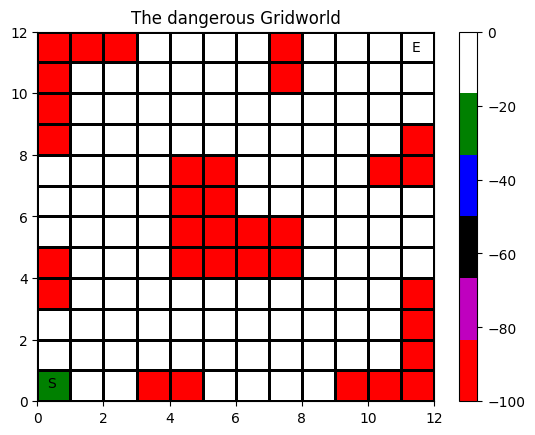

In [4]:
#We need extend the functionalities of the Env class (the superclass here is the env class)
#This is the environment class: where our agent will learn.
class dangerous_gridWorld(Env):
  #override the the following, in the Env class
  def __init__(self, grid_specs=[12,12], start_state=[0, 0], end_state=[11, 11], danger_states = [[False, False, False, True, True, False, False, False, False, True, True, True],
                                                                                                  [False, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [False, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [True, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [True, False, False, False, True, True, True, True, False, False, False, False],
                                                                                                  [False, False, False, False, True, True, True, True, False, False, False, False],
                                                                                                  [False, False, False, False, True, True, False, False, False, False, False, False],
                                                                                                  [False, False, False, False, True, True,  False, False, False, False, True, True],
                                                                                                  [True, False, False, False, False, False, False, False, False, False, False, True],
                                                                                                  [True, False, False, False, False, False, False, False, False, False, False, False],
                                                                                                  [True, False, False, False, False, False, False, True, False, False, False, False],
                                                                                                  [True, True, True, False, False, False, False, True, False, False, False, False]]):

    #initialize out setting, state space, action and rewards
    self.grid_specs = grid_specs
    #Dynamics of the MDP
    #action space
    self.actions =  ['left', 'up', 'right', 'down']
    #state space (defines the shape of the gridworld)
    #the states in itself has the knowledge of whether it is dangerous
    self.states = [[Coordinate(i, j, danger_states[i][j]) for j in range(grid_specs[1])] for i in range(grid_specs[0])]
    #for a SSPP
    self.start_state = Coordinate(start_state[0], start_state[1], False)
    self.end_state = Coordinate(end_state[0], end_state[1], False)

    #since the transition probabilities are deterministic
    #(i.e.: next state and reward is determinitic and hence we don't need to define it)

  def get_D_i(self):
    D_i = np.zeros(shape=self.grid_specs, dtype=bool)
    for i in range(self.grid_specs[0]):
      for j in range(self.grid_specs[1]):
        if (self.states[i][j].danger==True):
          D_i[i][j] = True
        elif i==0 or j==0:
          if i==0 and (j<self.grid_specs[1]-1 and self.states[i][j+1].danger == True) or (j-1>0 and self.states[i][j-1].danger == True):
            D_i[i][j] = True
          elif j==0 and (i<self.grid_specs[0]-1 and self.states[i+1][j].danger == True) or (i-1>0 and self.states[i-1][j].danger == True):
            D_i[i][j] = True
          else:
            D_i[i][j] = False
        elif i==self.grid_specs[0]-1 or j==self.grid_specs[1]-1:
          if i==self.grid_specs[0]-1 and (j<self.grid_specs[1]-1 and self.states[i][j+1].danger == True) or (j-1>0 and self.states[i][j-1].danger == True):
            D_i[i][j] = True
          elif j==self.grid_specs[1]-1 and (i<self.grid_specs[0]-1 and self.states[i+1][j].danger == True) or (i-1>0 and self.states[i-1][j].danger == True):
            D_i[i][j] = True
          else:
            D_i[i][j] = False
        elif (self.states[i+1][j].danger == True or self.states[i-1][j].danger == True) or (self.states[i][j+1].danger == True or self.states[i][j-1].danger ==True):
          D_i[i][j] = True
    return D_i

  def step(self, state, action):
    #current state is of Coordinate type and action is a single string

    #define the dynamics of a single step
    #(0,0) is the start state and (7, 7) is the terminal state
    #Going outside the grid incurs a penalty of -5 and entering the dangerous states makes the penalty be as high as -20 (hoping teacher can save the day)
    #x axis and y axis are inverted here
    next_state = None
    #flag_out = False
    reward = -1
    if action == 'left':
      if state.y - 1 < 0:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #flag_out = True
      else:
        next_state = self.states[state.x][state.y-1]

    elif action == "up":
      if state.x + 1 > self.end_state.x:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #went out of the grid
      else:
        next_state = self.states[state.x+1][state.y]

    elif action == "right":
      if state.y + 1 > self.end_state.y:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #went out of the grid
      else:
        next_state = self.states[state.x][state.y+1]
        #if the next state is a danger state: then a reward of -20 will be encountered

    elif action == "down":
      if state.x - 1 < 0:
        #going out of the grid
        next_state = self.states[state.x][state.y]
        #flag_out = True
      else:
        next_state = self.states[state.x-1][state.y]
        #if the next state is a danger state: then a reward of -20 will be encountered
    else:
      print("Invalid Action")
      next_state = state
      reward = 0

    #if flag_out== True:
    #  reward = -20
    #if the next state is a danger state: then a reward of -20 will be encountered
    if self.states[next_state.x][next_state.y].danger == True:
      reward = -100

    done = False
    if next_state.x == self.end_state.x and next_state.y == self.end_state.y:
      done = True
    #an empty dictionary needs to be returned as prescribed by the documents. This is used for returning any extra information
    info = {}
    return next_state, reward, done, info

  def render(self, current_state, title=""):
    #render graphics for the environment
    mesh_gd = np.zeros((self.end_state.x+1, self.end_state.y+1))
    for i in range(mesh_gd.shape[0]):
      for j in range(mesh_gd.shape[1]):
        if self.states[i][j].danger == True:
          mesh_gd[i][j] = -100
        else:
          mesh_gd[i][j] = 0
    mesh_gd[current_state.x][current_state.y] = -20
    plt.pcolormesh(mesh_gd, edgecolors='black', linewidth=2, cmap = col.ListedColormap(['r', 'm', 'k', 'b', 'g', 'w']))
    plt.colorbar()
    #adjusting text according to the relative positioning
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The dangerous Gridworld"+title)

  def disp2(self, dang_states):
    mesh_gd = np.zeros((self.end_state.x+1, self.end_state.y+1))
    for i in range(mesh_gd.shape[0]):
      for j in range(mesh_gd.shape[1]):
        if self.states[i][j].danger == True:
          mesh_gd[i][j] = -100
        elif dang_states[i][j] == True:
          mesh_gd[i][j] = -40
        else:
          mesh_gd[i][j] = 0

    plt.pcolormesh(mesh_gd, edgecolors='black', linewidth=2, cmap = col.ListedColormap(['r', 'y', 'w']))
    plt.colorbar()
    #adjusting text according to the relative positioning
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The teacher's knowledge of the grid world")

  def reset(self):
    #reset at the end of an episode
    return self.start_state

  def is_terminal(self, state):
    if state.x == self.end_state.x and state.y == self.end_state.y:
      return True
    return False

  def __str__(self):
    print("states: ")
    for i in range(self.grid_specs[0]):
      for j in range(self.grid_specs[1]):
        print(self.states[i][j])
    print('Start State: {}'.format(self.start_state))
    print('End State: {}'.format(self.end_state))
    return "actions: {}".format(self.actions)

gw = dangerous_gridWorld()
#gw.render(Coordinate(0, 0, True))
gw.render(gw.start_state)
#gw.render(gw.end_state)
#n_state, reward = gw.step(gw.states[1][2], "down")
#print(n_state, reward)

# Q-learning Algorithm

$$\large Q_\pi(s, a) = \sum_{s', r} p(s'| s, a)[r(s, a, s') + \max_{a'\in\mathcal{A}(s')} \gamma Q_\pi(s', a')]$$

Implemented by exploring the world using the policy
$$\large Q_{n+1}(s, a) = Q_{n}(s, a) + \alpha_{n+1}(s,a) [r(s, a, s') + \max_{a'\in\mathcal{A}(s')} \gamma Q_\pi(s', a') - Q_{n}(s, a)]$$

Completed run 0
Completed run 2000
Completed run 4000
Completed run 6000
Completed run 8000


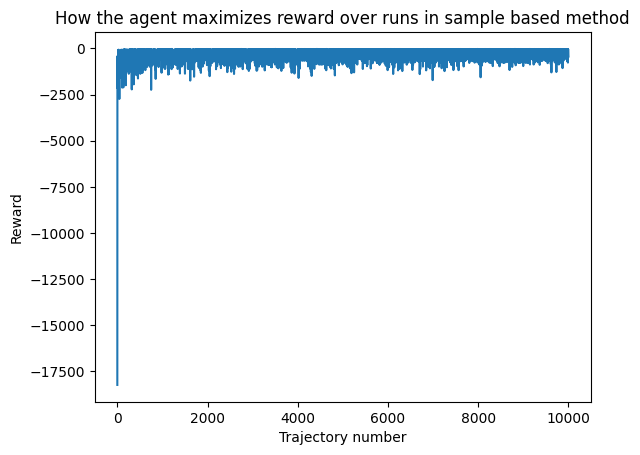

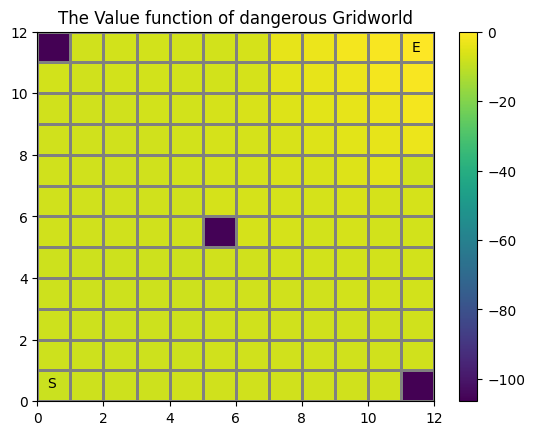

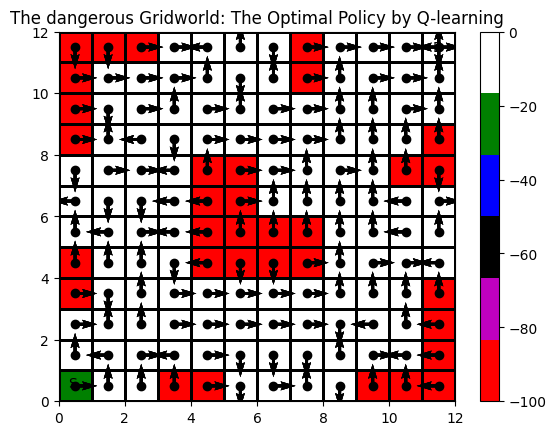

In [5]:
#testing the environment with sample based methods: Used (Q-learning): OFF Policy learning rule
class Q_learning_Agent(object):
  def __init__(self, env, eps=0.1):
    #eps -- for epsilon greedy sampling
    #for tabular methods V and pi is sufficient (Here we are trying to maximize reward)
    #Q-function
    self.Q = np.zeros((env.grid_specs[0], env.grid_specs[1], len(env.actions)))
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
    self.pi_indicator = np.zeros((env.grid_specs[0], env.grid_specs[1], len(env.actions)))
    #target policy: argmax (always choosing the best action)
    #behaviour policy: argmax (epsilon greedy), select action in state S according to this
    #discount factor
    self.gamma = 1
    self.epsilon = eps
    #present dynamics
    self.prev_state = None
    self.prev_action = None
    #this is for scheduling the learning rate
    self.num_visit = np.zeros((env.grid_specs[0], env.grid_specs[1], len(env.actions)))

  def reset(self, env):
    #for tabular methods V and pi is sufficient (Here we are trying to maximize reward)
    #Q-function
    self.Q = np.zeros((env.grid_specs[0], env.grid_specs[1], len(env.actions)))
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
    self.pi_indicator = np.zeros((env.grid_specs[0], env.grid_specs[1], len(env.actions)))
    #target policy: argmax (always choosing the best action)
    #behaviour policy: argmax (epsilon greedy), select action in state S according to this
    self.prev_state = None
    self.prev_action = None
    #this is for scheduling the learning rate
    self.num_visit = np.zeros((env.grid_specs[0], env.grid_specs[1], len(env.actions)))

  def lr_scheduler(self, this_state, action):
    #a = b = 1 (lr = a/(m+b) : for the mth update)
    #return 0.1
    return 1/(1+self.num_visit[this_state.x, this_state.y, action])

  #breaks ties randomly
  def argmax(self, vec):
    import math
    max_value = np.max(vec)
    ctr = 0
    all_maxpos = []
    for val in vec:
      if math.isclose(val, max_value):
        all_maxpos.append(ctr)
      ctr += 1
    return all_maxpos

  #this is for exploration/exploration tradeoff
  def behav_action(self, env):
    qval_prev_state = self.Q[self.prev_state.x, self.prev_state.y, :]
    #this breaks ties randomly
    sample_uni_0_1 = np.random.random()
    #with prob 1-eps we choose a 'good' action
    if sample_uni_0_1 > self.epsilon:
      #here only faesible actions compete
      return np.random.choice(self.argmax(qval_prev_state))
    else:
      return np.random.choice(len(qval_prev_state))

  def target_action(self, env, this_state):
    #this will return the best action in a particular state
    return np.random.choice(self.argmax(self.Q[this_state.x, this_state.y, :]))

  def start(self, env):
    #this is a beginning of an episode
    self.prev_state = env.start_state
    #here action is chosen in accordance to the behaviour policy of the agent
    #we are choosing this action as a number, convert to actual action using env.actions
    #take action in an offpolicy way (here we are using epsilon greedy)
    self.prev_action = self.behav_action(env)

  def step(self, env, cumu_reward):
    #first 2 components represent the state and the second one represent the reward
    this_state, reward, _, _ = env.step(self.prev_state, env.actions[self.prev_action])
    cumu_reward += reward

    if env.is_terminal(this_state) == True:
      return self.end(env, reward), cumu_reward

    #this is chosen with respect to the target policy (what we wish to learn)
    maximizing_action = self.target_action(env, this_state)
    #Q-learning update rule  -- r + max_a' Q(s',a') - Q(s,a)   --- s' is the this_state
    del_t = reward + self.gamma*self.Q[this_state.x, this_state.y, maximizing_action] - self.Q[self.prev_state.x, self.prev_state.y, self.prev_action]

    self.Q[self.prev_state.x, self.prev_state.y, self.prev_action] = self.Q[self.prev_state.x, self.prev_state.y, self.prev_action] + self.lr_scheduler(self.prev_state, self.prev_action)*del_t

    #Now we are in the next_state
    self.prev_state = this_state
    self.prev_action = self.behav_action(env)
    return False, cumu_reward

  def end(self, env, reward):
    #whenever this_state will be the end_state this will be called, for the end state you don't see the next state
    del_t = reward - self.Q[self.prev_state.x, self.prev_state.y, self.prev_action]

    self.Q[self.prev_state.x, self.prev_state.y, self.prev_action] = self.Q[self.prev_state.x, self.prev_state.y, self.prev_action] + self.lr_scheduler(self.prev_state, self.prev_action)*del_t
    #returns true when the current path ends
    return True

  def complete_trajectory(self, env):
    completed = False
    reward_rec = 0
    #this completes a trajectory
    while True:
      prev_state= self.prev_state
      prev_action = self.prev_action
      completed, reward_rec = self.step(env, reward_rec)
      if completed == True:
        break
      #updating the number of visits
      self.num_visit[prev_state.x, prev_state.y, prev_action] += 1
    return reward_rec

  def q_learning(self, env, max_runs=5000, avg_over=5):
    history = np.zeros((avg_over, max_runs))
    for a in range(avg_over):
      self.reset(env)
      for i in range(max_runs):
        self.start(env)
        history[a, i] = self.complete_trajectory(env)
        if i%2000 == 0:
          print("Completed run {}".format(i))

    avg_history = np.mean(history, axis=0)
    plt.plot(avg_history)
    plt.xlabel("Trajectory number")
    plt.ylabel("Reward")
    plt.title("How the agent maximizes reward over runs in sample based method")
    plt.show()
    return avg_history

  def compute_V_and_pi(self):
    #computes V* and pi*
    self.V = np.max(self.Q, axis=2)
    for i in range(self.V.shape[0]):
      for j in range(self.V.shape[1]):
        opt_act = self.argmax(self.Q[i, j, :])
        for ac in opt_act:
          self.pi_indicator[i, j, ac] = 1

  def display_num_visits(self):
    #env.render(env.start_state)
    plt.pcolormesh(np.sum(self.num_visit, axis=2), edgecolors='grey')
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("number of visits in each state")
    plt.colorbar()
    plt.show()
    #print(self.V)

  def print_optimal_value_function(self, env):
    #env.render(env.start_state)
    plt.pcolormesh(self.V, edgecolors='grey')
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The Value function of dangerous Gridworld")
    plt.colorbar()
    plt.show()
    #print(self.V)

  def print_optimal_policy(self, env):
    env.render(env.states[0][0], ": The Optimal Policy by Q-learning")
    for i in range(env.grid_specs[0]):
       for j in range(env.grid_specs[1]):
        plt.scatter(i+0.5, j+0.5, color='black')
        for k in range(len(env.actions)):
          #print arrow (x, y, dx, dy)
          #print along j first (because here we are printing from row-wise from bottom to up but pi_indicator,
          #and quiver follow caresian convention, which is opposite of pcolormesh convention)
          if self.pi_indicator[i, j, 0]==1:
            #left
            plt.quiver(j+0.5, i+0.5, -0.5, 0, color='black')
          if self.pi_indicator[i, j, 1]==1:
            #up
            plt.quiver(j+0.5, i+0.5, 0, 0.5, color='black')
          if self.pi_indicator[i, j, 2]==1:
            #right
            plt.quiver(j+0.5, i+0.5, 0.5, 0, color='black')
          if self.pi_indicator[i, j, 3]==1:
            #down
            plt.quiver(j+0.5, i+0.5, 0, -0.5, color='black')

q_agent = Q_learning_Agent(gw, 0.33)
q_agent.q_learning(gw, 10000, 1)
q_agent.compute_V_and_pi()
q_agent.print_optimal_value_function(gw)
q_agent.print_optimal_policy(gw)

# TD Learning

### Equations and Explanations

#### TD(0) -- Model Free

We consider episodic tasks here.

$$\large V_\pi(s) = \sum_{a \in \mathcal{A}(s)} \pi(a|s) \sum_{s', r} p(s' | s, a)[r(s, a, s') + V_\pi(s')]$$

Implemented by exploring the world using the policy.

for 1 step (s, a, s') and observed reward(s, a, s' ), the TD(0) update will be for the policy $\pi$ --



$$\large V_{n+1}(s) = V_{n}(s) + \alpha_{n+1}(s) [r(s, a, s') +  V_n(s') - V_n(s)]$$

as $n \rightarrow \infty, V_n \rightarrow V_\pi$

#### TD($\lambda$) -- Model Free

the TD($\lambda$) update will be for the policy $\pi$ --


$$\large V_{n+1}(s_k) = V_{n}(s_k) + \gamma_{n+1}(s_k) [\sum_{i=k}^{\infty} \lambda^i d_i^m]$$
where $$ d_i^n = r(s_i, a_i, s_{i+1}) + V_n(s_{i+1}) - V_n(s_i)$$

as $n \rightarrow \infty, V_n \rightarrow V_\pi$


#### TD Lambda explained

````def TD_lambda_learning(self, env, lam=0.8, max_runs=5000, avg_over=1):
    history = np.zeros((avg_over, max_runs))  # To store cumulative rewards for plotting
    for a in range(avg_over):                 # For averaging over multiple runs
        self.reset(env)
        for i in range(max_runs):             # For each episode
            
            
            # Completely run the episode

            states = []
            rewards = []
            self.start(env)
            _, states, rewards = self.complete_trajectory(env, return_trajectory=True)



            #  Compute TD errors for the episode


            deltas = []
            for t in range(len(states)):
                s = states[t]
                if t < len(states) - 1:
                    s_next = states[t+1]
                    r = rewards[t]
                    delta = r + self.gamma * self.V[s_next.x, s_next.y] - self.V[s.x, s.y]#as per eqn
                else:
                    # Last state (terminal)
                    delta = rewards[t] - self.V[s.x, s.y]#V_N=0
                deltas.append(delta)


            # For each state, compute the sum of d and update V
            for t in range(len(states)):
                G = 0                             
                for k in range(t, len(deltas)):
                    G += (lam ** (k - t)) * deltas[k] #weigh by lambda
                s = states[t]
                self.V[s.x, s.y] += self.lr_scheduler(s) * G  # Update V(s)
                self.num_visit[s.x, s.y] += 1                 # Track visits
            history[a, i] = np.sum(rewards)                   # Store total reward for this episode
            if i % 2000 == 0:
                print(f"Completed run {i}")


    #plot the Reward minimization


    avg_history = np.mean(history, axis=0)
    plt.plot(avg_history)
    plt.xlabel("Trajectory number")
    plt.ylabel("Reward")
    plt.title("How the agent maximizes reward over runs in TD(lambda)")
    plt.show()
    # return avg_history
    ````
    

### TD_Agent Class

In [10]:
#testing the environment with sample based methods: Used (Q-learning): OFF Policy learning rule
class TD_Agent(object):
  def __init__(self, env, pi=None, eps=0.1):
    #for tabular methods V and pi is sufficient (Here we are trying to maximize reward)
    #Q-function
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
    self.pi = pi
    #pi is the policy distribution you want to evaluate, else we work with uniform distributions
    if self.pi is None:
        #initially select a random policy
        self.pi_indicator = np.ones((env.grid_specs[0], env.grid_specs[1], len(env.actions)))  # ((x, y), a) -- dimensions
    else:
        self.pi_indicator = self.pi
    #discount factor
    self.eps = 0.1  #epsilon greedy parameter
    self.gamma = 1
    #present dynamics
    self.prev_state = None
    self.prev_action = None
    #this is for scheduling the learning rate
    self.num_visit = np.zeros((env.grid_specs[0], env.grid_specs[1]))

  def reset(self, env, pi=None):
    #for tabular methods V and pi is sufficient (Here we are trying to maximize reward)
    #V-function
    self.V = np.zeros((env.grid_specs[0], env.grid_specs[1]))
    if self.pi is None:
        #initially select a random policy
        self.pi_indicator = np.ones((env.grid_specs[0], env.grid_specs[1], len(env.actions)))  # ((x, y), a) -- dimensions
    else:
        self.pi_indicator = self.pi
    #target policy: argmax (always choosing the best action)
    self.prev_state = None
    self.prev_action = None
    #this is for scheduling the learning rate according to the state
    self.num_visit = np.zeros((env.grid_specs[0], env.grid_specs[1]))

  def lr_scheduler(self, this_state):
    #a = b = 1 (lr = a/(m+b) : for the mth update)
    #return 0.1
    return 1/(1+self.num_visit[this_state.x, this_state.y])

  #this is for exploration/exploration tradeoff
  def select_action(self, env):
    # epsilon greedy action selection -- that is if less than eps select any action
    #else select randomly from equiprobable action
    if np.random.rand() < self.eps:
        return np.random.choice(len(env.actions))
    else:
        actions_valid = np.where(self.pi_indicator[self.prev_state.x, self.prev_state.y, :] == 1)[0]
        # choose from equally valid actions
        return np.random.choice(actions_valid)

  def start(self, env):
    #this is a beginning of an episode
    self.prev_state = env.start_state
    #here action is chosen in accordance to the behaviour policy of the agent
    #we are choosing this action as a number, convert to actual action using env.actions
    #take action in an offpolicy way (here we are using epsilon greedy)
    self.prev_action = self.select_action(env)

  def step(self, env, cumu_reward):
    #first 2 components represent the state and the second one represent the reward
    this_state, reward, _, _ = env.step(self.prev_state, env.actions[self.prev_action])
    cumu_reward += reward

    if env.is_terminal(this_state) == True:
      return self.end(env, reward), cumu_reward

    #TD(0)-learning update rule  -- r(s, a, s') + V(s') - V(s) --- s' is the this_state
    del_t = reward + self.gamma*self.V[this_state.x, this_state.y] - self.V[self.prev_state.x, self.prev_state.y]

    self.V[self.prev_state.x, self.prev_state.y] = self.V[self.prev_state.x, self.prev_state.y] + self.lr_scheduler(self.prev_state)*del_t

    #Now we are in the next_state
    self.prev_state = this_state
    self.prev_action = self.select_action(env)
    return False, cumu_reward

  def end(self, env, reward):
    #whenever this_state will be the end_state this will be called, for the end state you don't see the next state
    del_t = reward - self.V[self.prev_state.x, self.prev_state.y]

    self.V[self.prev_state.x, self.prev_state.y] = self.V[self.prev_state.x, self.prev_state.y] + self.lr_scheduler(self.prev_state)*del_t
    #returns true when the current path ends
    return True

  def complete_trajectory(self, env, return_trajectory=False):#this completes a trajectory
    #if return_trajectory is True, then it returns the states and rewards encountered in the trajectory
    #if return_trajectory is False, then it returns the cumulative reward only[as per old code]
    # self.prev_state = env.start_state
    # self.prev_action = self.select_action(env) done in start()
    #reset the number of visits
    completed = False
    reward_rec = 0
    states = []
    rewards = []
    while True:
        prev_state = self.prev_state
        prev_action = self.prev_action
        completed, reward_rec = self.step(env, reward_rec)
        if return_trajectory:
            states.append(prev_state)
            # The reward for this step is the difference in reward_rec
            if len(rewards) == 0:
                rewards.append(reward_rec)
            else:
                rewards.append(reward_rec - sum(rewards))
        self.num_visit[prev_state.x, prev_state.y] += 1
        if completed:
            break
    if return_trajectory:
        return reward_rec, states, rewards
    else:
        return reward_rec

  def TD0_learning(self, env, max_runs=5000, avg_over=5):
    history = np.zeros((avg_over, max_runs))
    for a in range(avg_over):
      self.reset(env)
      for i in range(max_runs):
        self.start(env)
        history[a, i] = self.complete_trajectory(env)
        if i%2000 == 0:
          print("Completed run {}".format(i))

    avg_history = np.mean(history, axis=0)
    plt.plot(avg_history)
    plt.xlabel("Trajectory number")
    plt.ylabel("Reward")
    plt.title("How the agent maximizes reward over runs in sample based method")
    plt.show()
    return avg_history

  def display_num_visits(self):
    #env.render(env.start_state)
    plt.pcolormesh(np.sum(self.num_visit, axis=2), edgecolors='grey')
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("number of visits in each state")
    plt.colorbar()
    plt.show()
    #print(self.V)

  def print_value_function(self, env):
    #env.render(env.start_state)
    plt.pcolormesh(self.V, edgecolors='grey')
    plt.figtext(0.71, 0.84, "E")
    plt.figtext(0.14, 0.14, "S")
    plt.title("The Value function of dangerous Gridworld")
    plt.colorbar()
    plt.show()
    #print(self.V)

  def print_policy(self, env):
    env.render(env.states[0][0], ": The Optimal Policy by Q-learning")
    for i in range(env.grid_specs[0]):
       for j in range(env.grid_specs[1]):
        plt.scatter(i+0.5, j+0.5, color='black')
        for k in range(len(env.actions)):
          #print arrow (x, y, dx, dy)
          #print along j first (because here we are printing from row-wise from bottom to up but pi_indicator,
          #and quiver follow caresian convention, which is opposite of pcolormesh convention)
          if self.pi_indicator[i, j, 0]==1:
            #left
            plt.quiver(j+0.5, i+0.5, -0.5, 0, color='black')
          if self.pi_indicator[i, j, 1]==1:
            #up
            plt.quiver(j+0.5, i+0.5, 0, 0.5, color='black')
          if self.pi_indicator[i, j, 2]==1:
            #right
            plt.quiver(j+0.5, i+0.5, 0.5, 0, color='black')
          if self.pi_indicator[i, j, 3]==1:
            #down
            plt.quiver(j+0.5, i+0.5, 0, -0.5, color='black')

  def TD_lambda_learning(self, env, lam=0.8, max_runs=5000, avg_over=1, lamarr=None):
    # If lamarr is not provided, use a single lambda value as before
      if lamarr is None:
          lamarr = [lam]
      history = np.zeros((len(lamarr), avg_over, max_runs))  # 3D: lambda, avg_over, episodes

      for lidx, lam in enumerate(lamarr):
          for a in range(avg_over):
              self.reset(env)
              for i in range(max_runs):
                  states = []
                  rewards = []
                  self.start(env)
                  _, states, rewards = self.complete_trajectory(env, return_trajectory=True)
                  # Compute TD errors for the episode
                  deltas = []
                  for t in range(len(states)):
                      s = states[t]
                      if t < len(states) - 1:
                          s_next = states[t+1]
                          r = rewards[t]
                          delta = r + self.gamma * self.V[s_next.x, s_next.y] - self.V[s.x, s.y]
                      else:
                          delta = rewards[t] - self.V[s.x, s.y]
                      deltas.append(delta)
                  # For each state, compute the sum of d and update V
                  for t in range(len(states)):
                      G = 0
                      for k in range(t, len(deltas)):
                          G += (lam ** (k - t)) * deltas[k]
                      s = states[t]
                      self.V[s.x, s.y] += self.lr_scheduler(s) * G
                      self.num_visit[s.x, s.y] += 1
                  history[lidx, a, i] = np.sum(rewards)
                  if i % 2000 == 0:
                      print(f"Completed run {i} for lambda={lam}")
      # Plot for each lambda
      for lidx, lam in enumerate(lamarr):
          avg_history = np.mean(history[lidx], axis=0)
          plt.plot(avg_history, label=f"lambda={lam}")
      plt.xlabel("Trajectory number")
      plt.ylabel("Reward")
      plt.title("How the agent maximizes reward over runs in TD(lambda)")
      plt.legend()
      plt.show()
      # return history if needed

### Outputs

#### Uniform Policy

#### TD(0)

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


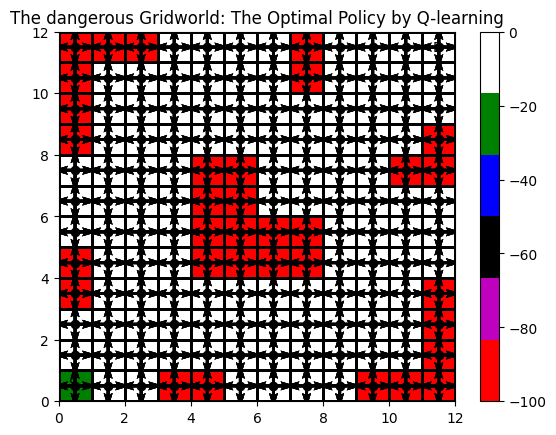

In [11]:
td_agent = TD_Agent(gw)
td_agent.print_policy(gw)

Completed run 0
Completed run 2000
Completed run 4000
Completed run 6000
Completed run 8000


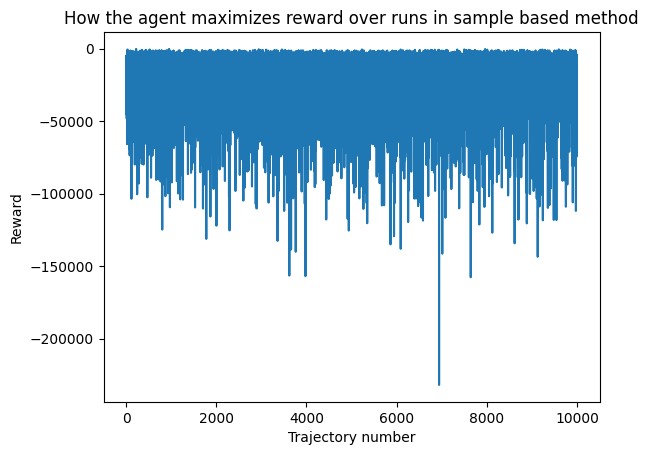

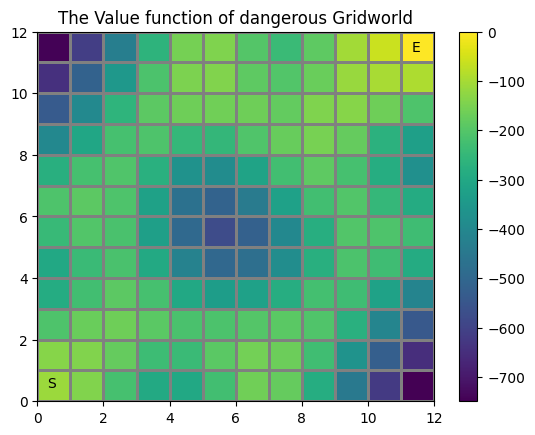

In [ ]:
td_agent.TD0_learning(gw, 10000, 1)
td_agent.print_value_function(gw)

#### TD (Lambda)

Completed run 0 for lambda=0.8


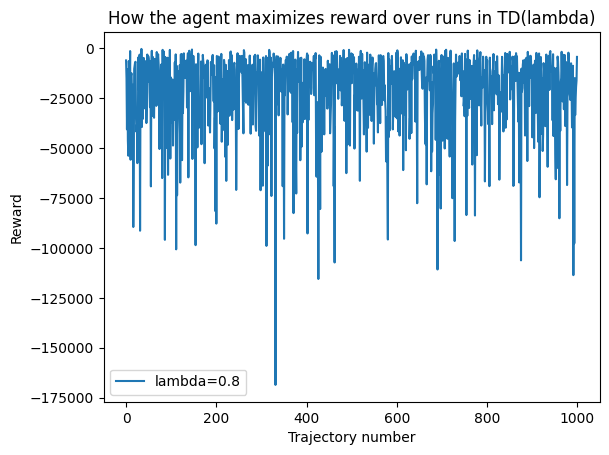

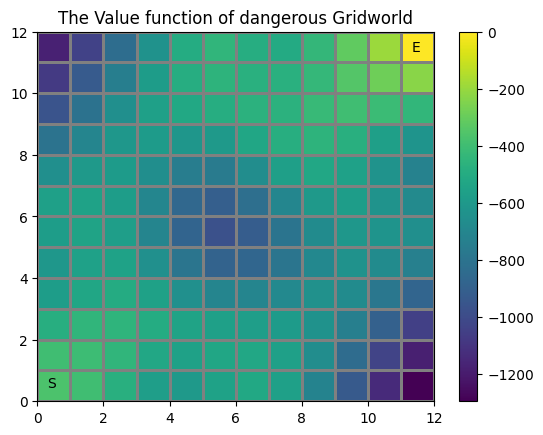

In [14]:
#td_agent = TD_Agent(gw)
td_agent.TD_lambda_learning(gw, lam=0.8, max_runs=1000, avg_over=1)
td_agent.print_value_function(gw)

#### Optimal Policy (by using Q learning)

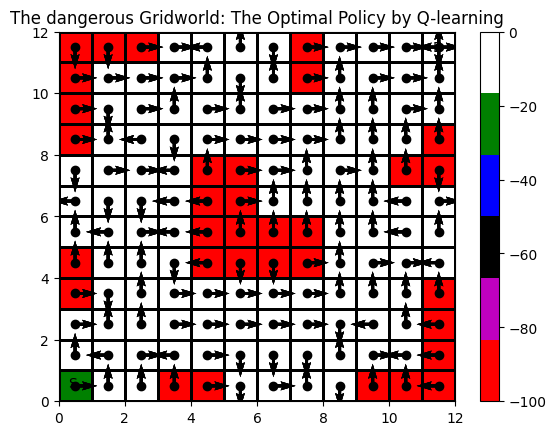

In [15]:
td_agent1 = TD_Agent(gw, q_agent.pi_indicator)
td_agent1.print_policy(gw)

#### TD0

Completed run 0
Completed run 2000
Completed run 4000
Completed run 6000
Completed run 8000


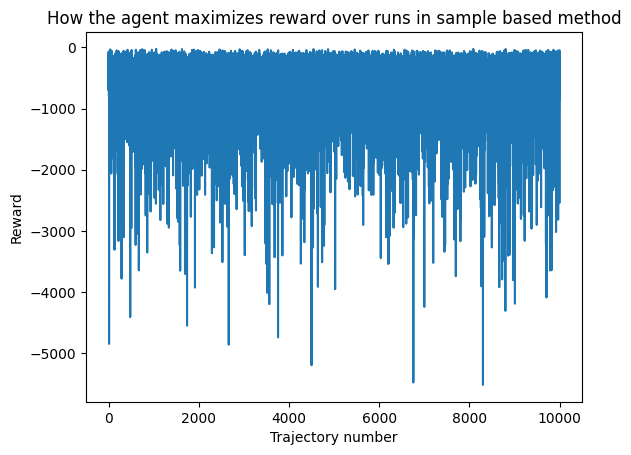

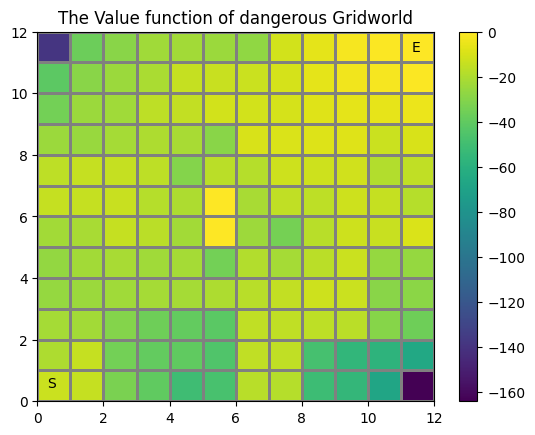

In [ ]:
td_agent1.TD0_learning(gw, 10000, 1)
td_agent1.print_value_function(gw)

#### TD(Lambda)

Completed run 0
Completed run 2000
Completed run 4000
Completed run 6000
Completed run 8000


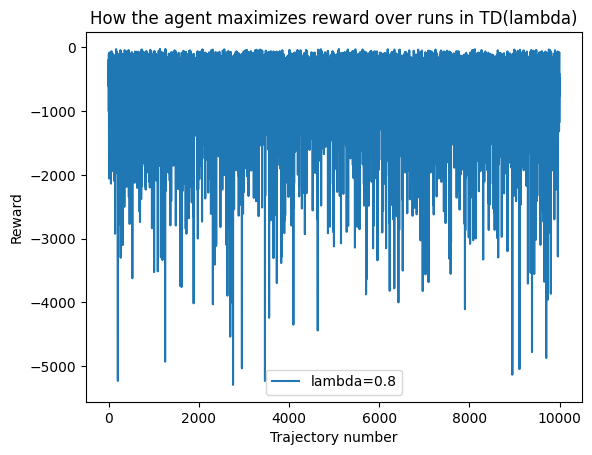

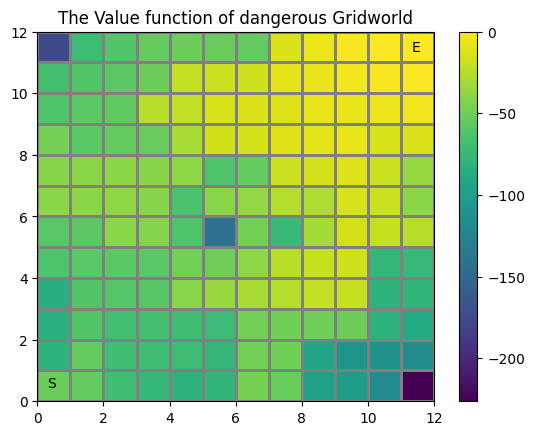

In [ ]:
#td_agent = TD_Agent(gw, q_agent.pi_indicator)
td_agent1.TD_lambda_learning(gw, lam=0.8, max_runs=10000, avg_over=1)
td_agent1.print_value_function(gw)

#### Compare across various values of lambda

Completed run 0 for lambda=0
Completed run 2000 for lambda=0
Completed run 4000 for lambda=0
Completed run 6000 for lambda=0
Completed run 8000 for lambda=0
Completed run 0 for lambda=0.5
Completed run 2000 for lambda=0.5
Completed run 4000 for lambda=0.5
Completed run 6000 for lambda=0.5
Completed run 8000 for lambda=0.5
Completed run 0 for lambda=1.0
Completed run 2000 for lambda=1.0
Completed run 4000 for lambda=1.0
Completed run 6000 for lambda=1.0
Completed run 8000 for lambda=1.0


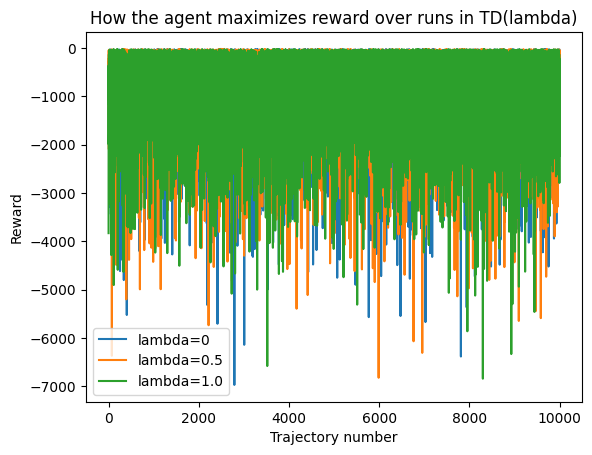

In [16]:
lambda_values = [0, 0.5, 1.0]
td_agent1.TD_lambda_learning(gw, max_runs=10000, avg_over=1,lamarr=lambda_values)